In [51]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import resnet
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
import seaborn as sns
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.11.0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080', major=8, minor=6, total_memory=10239MB, multi_processor_count=68)


In [52]:
#https://www.kaggle.com/code/halfendt/dog-breed-classifier-pytorch-resnet-152
def load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std):
    train_transform = transforms.Compose([
                                         #transforms.RandomRotation(degrees=15),
                                         #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                         #transforms.RandomResizedCrop((224,224)),
                                         transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(torch.Tensor(mean),
                                                              torch.Tensor(std))])

    test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        #transforms.CenterCrop((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean),
                                                             torch.Tensor(std))])

    val_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       #transforms.CenterCrop((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

    if presplit:
        try:
            training_set = datasets.ImageFolder(root=images_path+'/train', transform=train_transform)
            validation_set = datasets.ImageFolder(root=images_path+'/val', transform=val_transform)
        except FileNotFoundError:
            raise Exception('Not presplit into Training and Validation sets')
        try:
            testing_set = datasets.ImageFolder(root=images_path+'/test', transform=test_transform)
        except:
            testing_set = validation_set
        dataset = training_set
    else:
        dataset = datasets.ImageFolder(root=images_path, transform=train_transform)
        train_size = int(train_split * len(dataset))
        test_size = int(test_split * len(dataset))
        val_size = len(dataset) - train_size - test_size
        training_set, testing_set, validation_set = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

    training_set_loader = DataLoader(training_set, batch_size=batch_size, num_workers=threads, shuffle=True, pin_memory=True)
    validation_set_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=threads, shuffle=True, pin_memory=True)
    testing_set_loader = DataLoader(testing_set, batch_size=batch_size, num_workers=threads, shuffle=False, pin_memory=True)

    return training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set

In [53]:
images_path = './data/images/Images/'
results_path = images_path+'_results'
presplit = False
train_split = 0.7
val_split = 0.2
test_split = 0.1
batch_size = 64
threads = 18
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set = \
                  load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std)

In [54]:
from torch.hub import load_state_dict_from_url
import torch

from functools import partial
from torch import nn, Tensor
from torch.nn import functional as F
from typing import Any, Callable, Dict, List, Optional, Sequence

#from torchvision.models.utils import load_state_dict_from_url
from torchvision.models.mobilenetv2 import _make_divisible, ConvBNActivation


__all__ = ["MobileNetV3", "mobilenet_v3_large", "mobilenet_v3_small"]


model_urls = {
    "mobilenet_v3_large": "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth",
    "mobilenet_v3_small": "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth",
}


class SqueezeExcitation(nn.Module):

    def __init__(self, input_channels: int, squeeze_factor: int = 4):
        super().__init__()
        squeeze_channels = _make_divisible(input_channels // squeeze_factor, 8)
        self.fc1 = nn.Conv2d(input_channels, squeeze_channels, 1)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(squeeze_channels, input_channels, 1)

    def _scale(self, input: Tensor, inplace: bool) -> Tensor:
        scale = F.adaptive_avg_pool2d(input, 1)
        scale = self.fc1(scale)
        scale = self.relu(scale)
        scale = self.fc2(scale)
        return F.hardsigmoid(scale, inplace=inplace)

    def forward(self, input: Tensor) -> Tensor:
        scale = self._scale(input, True)
        return scale * input


class InvertedResidualConfig:

    def __init__(self, input_channels: int, kernel: int, expanded_channels: int, out_channels: int, use_se: bool,
                 activation: str, stride: int, dilation: int, width_mult: float):
        self.input_channels = self.adjust_channels(input_channels, width_mult)
        self.kernel = kernel
        self.expanded_channels = self.adjust_channels(expanded_channels, width_mult)
        self.out_channels = self.adjust_channels(out_channels, width_mult)
        self.use_se = use_se
        self.use_hs = activation == "HS"
        self.stride = stride
        self.dilation = dilation

    @staticmethod
    def adjust_channels(channels: int, width_mult: float):
        return _make_divisible(channels * width_mult, 8)


class InvertedResidual(nn.Module):

    def __init__(self, cnf: InvertedResidualConfig, norm_layer: Callable[..., nn.Module],
                 se_layer: Callable[..., nn.Module] = SqueezeExcitation):
        super().__init__()
        if not (1 <= cnf.stride <= 2):
            raise ValueError('illegal stride value')

        self.use_res_connect = cnf.stride == 1 and cnf.input_channels == cnf.out_channels

        layers: List[nn.Module] = []
        activation_layer = nn.Hardswish if cnf.use_hs else nn.ReLU

        # expand
        if cnf.expanded_channels != cnf.input_channels:
            layers.append(ConvBNActivation(cnf.input_channels, cnf.expanded_channels, kernel_size=1,
                                           norm_layer=norm_layer, activation_layer=activation_layer))

        # depthwise
        stride = 1 if cnf.dilation > 1 else cnf.stride
        layers.append(ConvBNActivation(cnf.expanded_channels, cnf.expanded_channels, kernel_size=cnf.kernel,
                                       stride=stride, dilation=cnf.dilation, groups=cnf.expanded_channels,
                                       norm_layer=norm_layer, activation_layer=activation_layer))
        if cnf.use_se:
            layers.append(se_layer(cnf.expanded_channels))

        # project
        layers.append(ConvBNActivation(cnf.expanded_channels, cnf.out_channels, kernel_size=1, norm_layer=norm_layer,
                                       activation_layer=nn.Identity))

        self.block = nn.Sequential(*layers)
        self.out_channels = cnf.out_channels
        self._is_cn = cnf.stride > 1

    def forward(self, input: Tensor) -> Tensor:
        result = self.block(input)
        if self.use_res_connect:
            result += input
        return result


class MobileNetV3(nn.Module):

    def __init__(
            self,
            inverted_residual_setting: List[InvertedResidualConfig],
            last_channel: int,
            num_classes: int = 120,
            block: Optional[Callable[..., nn.Module]] = None,
            norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        """
        MobileNet V3 main class

        Args:
            inverted_residual_setting (List[InvertedResidualConfig]): Network structure
            last_channel (int): The number of channels on the penultimate layer
            num_classes (int): Number of classes
            block (Optional[Callable[..., nn.Module]]): Module specifying inverted residual building block for mobilenet
            norm_layer (Optional[Callable[..., nn.Module]]): Module specifying the normalization layer to use
        """
        super().__init__()

        if not inverted_residual_setting:
            raise ValueError("The inverted_residual_setting should not be empty")
        elif not (isinstance(inverted_residual_setting, Sequence) and
                  all([isinstance(s, InvertedResidualConfig) for s in inverted_residual_setting])):
            raise TypeError("The inverted_residual_setting should be List[InvertedResidualConfig]")

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)

        layers: List[nn.Module] = []

        # building first layer
        firstconv_output_channels = inverted_residual_setting[0].input_channels
        layers.append(ConvBNActivation(3, firstconv_output_channels, kernel_size=3, stride=2, norm_layer=norm_layer,
                                       activation_layer=nn.Hardswish))

        # building inverted residual blocks
        for cnf in inverted_residual_setting:
            layers.append(block(cnf, norm_layer))

        # building last several layers
        lastconv_input_channels = inverted_residual_setting[-1].out_channels
        lastconv_output_channels = 6 * lastconv_input_channels
        layers.append(ConvBNActivation(lastconv_input_channels, lastconv_output_channels, kernel_size=1,
                                       norm_layer=norm_layer, activation_layer=nn.Hardswish))

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(lastconv_output_channels, last_channel),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(last_channel, num_classes),
            #added by me
            #nn.Softmax(dim=1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.features(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.classifier(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _mobilenet_v3_conf(arch: str, params: Dict[str, Any]):
    # non-public config parameters
    reduce_divider = 2 if params.pop('_reduced_tail', False) else 1
    dilation = 2 if params.pop('_dilated', False) else 1
    width_mult = params.pop('_width_mult', 1.0)

    bneck_conf = partial(InvertedResidualConfig, width_mult=width_mult)
    adjust_channels = partial(InvertedResidualConfig.adjust_channels, width_mult=width_mult)

    if arch == "mobilenet_v3_large":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, False, "RE", 1, 1),
            bneck_conf(16, 3, 64, 24, False, "RE", 2, 1),  # C1
            bneck_conf(24, 3, 72, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 72, 40, True, "RE", 2, 1),  # C2
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 5, 120, 40, True, "RE", 1, 1),
            bneck_conf(40, 3, 240, 80, False, "HS", 2, 1),  # C3
            bneck_conf(80, 3, 200, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 184, 80, False, "HS", 1, 1),
            bneck_conf(80, 3, 480, 112, True, "HS", 1, 1),
            bneck_conf(112, 3, 672, 112, True, "HS", 1, 1),
            bneck_conf(112, 5, 672, 160 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(160 // reduce_divider, 5, 960 // reduce_divider, 160 // reduce_divider, True, "HS", 1, dilation),
        ]
        last_channel = adjust_channels(1280 // reduce_divider)  # C5
    elif arch == "mobilenet_v3_small":
        inverted_residual_setting = [
            bneck_conf(16, 3, 16, 16, True, "RE", 2, 1),  # C1
            bneck_conf(16, 3, 72, 24, False, "RE", 2, 1),  # C2
            bneck_conf(24, 3, 88, 24, False, "RE", 1, 1),
            bneck_conf(24, 5, 96, 40, True, "HS", 2, 1),  # C3
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 1),
            bneck_conf(40, 5, 240, 40, True, "HS", 1, 1),
            bneck_conf(40, 5, 120, 48, True, "HS", 1, 1),
            bneck_conf(48, 5, 144, 48, True, "HS", 1, 1),
            bneck_conf(48, 5, 288, 96 // reduce_divider, True, "HS", 2, dilation),  # C4
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, dilation),
            bneck_conf(96 // reduce_divider, 5, 576 // reduce_divider, 96 // reduce_divider, True, "HS", 1, dilation),
        ]
        last_channel = adjust_channels(1024 // reduce_divider)  # C5
    else:
        raise ValueError("Unsupported model type {}".format(arch))

    return inverted_residual_setting, last_channel


def _mobilenet_v3_model(
    arch: str,
    inverted_residual_setting: List[InvertedResidualConfig],
    last_channel: int,
    pretrained: bool,
    progress: bool,
    **kwargs: Any
):
    model = MobileNetV3(inverted_residual_setting, last_channel, **kwargs)
    if pretrained:
        if model_urls.get(arch, None) is None:
            raise ValueError("No checkpoint is available for model type {}".format(arch))
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


def mobilenet_v3_large(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> MobileNetV3:
    """
    Constructs a large MobileNetV3 architecture from
    `"Searching for MobileNetV3" <https://arxiv.org/abs/1905.02244>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    arch = "mobilenet_v3_large"
    inverted_residual_setting, last_channel = _mobilenet_v3_conf(arch, kwargs)
    return _mobilenet_v3_model(arch, inverted_residual_setting, last_channel, pretrained, progress, **kwargs)



def mobilenet_v3_small(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> MobileNetV3:
    """
    Constructs a small MobileNetV3 architecture from
    `"Searching for MobileNetV3" <https://arxiv.org/abs/1905.02244>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    arch = "mobilenet_v3_small"
    inverted_residual_setting, last_channel = _mobilenet_v3_conf(arch, kwargs)
    return _mobilenet_v3_model(arch, inverted_residual_setting, last_channel, pretrained, progress, **kwargs)


In [55]:
def validate():
	correct = 0
	total = 0
	model.eval()
	with torch.no_grad():
		for imgs, labels in validation_set_loader:
			imgs = imgs.to(device)
			labels = labels.to(device)
			batch_size=imgs.shape[0]
			outputs = model(imgs)
			_, predicted = torch.max(outputs, dim=1)
			total += labels.shape[0]
			correct += int((predicted==labels).sum())
		print("Accuracy ", correct/total)

In [56]:
import time
def training(model, optimizer, loss_fn, n_epochs, device, l2_lambda, train_loader):
	start = time.time()

	for epoch in range(n_epochs):
		if epoch == 25:
			#learning_rate = 1e-5
			validate()
			model.train()
		elif epoch == 10:
			#learning_rate = 1e-6
			validate()
			model.train()
		elif epoch == 40:
			#learning_rate = 1e-4
			validate()
			model.train()
		elif epoch == 30:
			#learning_rate = 1e-4
			validate()
			model.train()
		elif epoch == 5:
			#learning_rate = 1e-4
			validate()
			model.train()
		elif epoch == 200:
			#learning_rate = 1e-4
			validate()
			model.train()
		for imgs, labels in train_loader:
			imgs = imgs.to(device)
			labels = labels.to(device)
			batch_size = imgs.shape[0]
			outputs = model(imgs)
			loss = loss_fn((outputs), labels)
			# l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
			# loss = loss + l2_lambda* l2_norm

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
		print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
	end = time.time()
	print(end - start)

In [57]:
device = torch.device('cuda:0')
model = mobilenet_v3_large(pretrained=False).to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-3
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=.9, weight_decay=.9, eps=.002)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 75
l2_lambda = 1e-5

In [58]:
#training(model, optimizer, loss_function, n_epochs, device, l2_lambda, training_set_loader)
model.load_state_dict(torch.load("./models/80%ModelLarge.pt"))

<All keys matched successfully>

In [59]:
#torch.save(model.state_dict(), "./models/25EpochMobileNetRMS.pt")

In [60]:
validate()

Accuracy  0.3677435025504008


In [61]:
from ptflops import get_model_complexity_info


macs, params = get_model_complexity_info(model, (3, 224,224), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.23 GMac
Number of parameters:           4.36 M  


In [62]:
# def plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=14):
#     sampler = RandomSampler(training_set, num_samples=batch_size, replacement=True)
#     train_loader = DataLoader(training_set, sampler=sampler, shuffle=False, batch_size=batch_size, num_workers=0)
#
#     dataiter = iter(train_loader)
#     images, labels = dataiter.next()
#
#     plt.figure(figsize=(size,size))
#     for i in range(rows*columns):
#         plt.subplot(rows, columns, i+1)
#         plt.title(class_names[labels.numpy()[i]])
#         img = images[i].permute(1,2,0)
#         img = torch.tensor(std)*img + torch.tensor(mean)
#         plt.axis('off')
#         plt.imshow(img, interpolation='none')
#         plt.tight_layout()

In [63]:
class_names = dataset.classes
class_names = [classes for classes in class_names]

In [64]:
# plot_grid_images(training_set, 64, class_names, mean, std)

In [65]:
batch_size = 1
threads = 18
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set = \
                  load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std)

In [66]:
model.eval()
i = 0
true = 0
for img, label in validation_set_loader:
    img = img.to(device)
   # print(img.shape)
    label = label.to(device)
    output = model(img)
    # print("--------------------------------")
    # print("prediction: " + str(class_names[torch.argmax(output)]))
    # print(torch.argmax(output))
    # print("ground truth: " + str(class_names[label]))
    # print(label)
    # print("--------------------------------")
    # print("\n")
    if torch.argmax(output) == label:
        true += 1
    i += 1
print(true/i)

0.8037405878066554


In [67]:
def test_model(model_name, model, test_loader):
    #model.load_state_dict(torch.load('/kaggle/working/'+str(model_name)+'.pth'))

    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    preds = []
    trues = []

    for i, (inputs, targets) in enumerate(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            pred = model(inputs).data.cuda().cpu().numpy().copy()
        else:
            pred = model(inputs).data.numpy().copy()

        true = targets.numpy().copy()
        preds.append(pred)
        trues.append(true)

        if i % (len(test_loader)//5) == 0:
            print(f'Iteration {i+1}/{len(test_loader)}')
    return np.concatenate(preds), np.concatenate(trues)

In [68]:
preds_test, y_true = test_model('mobilenet', model, validation_set_loader)

Iteration 1/4117
Iteration 824/4117
Iteration 1647/4117
Iteration 2470/4117
Iteration 3293/4117
Iteration 4116/4117


In [69]:
def display_confusion_matrix(results_path, model_name, y_true, preds, class_names, annot, figsize=(9,7), fontsize=14):
    #if not os.path.exists(results_path+'/'+model_name):
    #    os.makedirs(results_path+'/'+model_name)

    acc = accuracy_score(y_true, preds.argmax(1))
    score = f1_score(y_true, preds.argmax(1), average='micro')
    cm = confusion_matrix(y_true, preds.argmax(1))
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    np.set_printoptions(precision=2)

    string1 = 'Confusion Matrix for Testing Data'
    string2 = f'Accuracy is {acc:0.3f}; F1-score is {score:0.3f}'
    title_str = string1.center(len(string2))+'\n'+string2

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=annot, annot_kws={'size': fontsize}, fmt='d')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title_str)

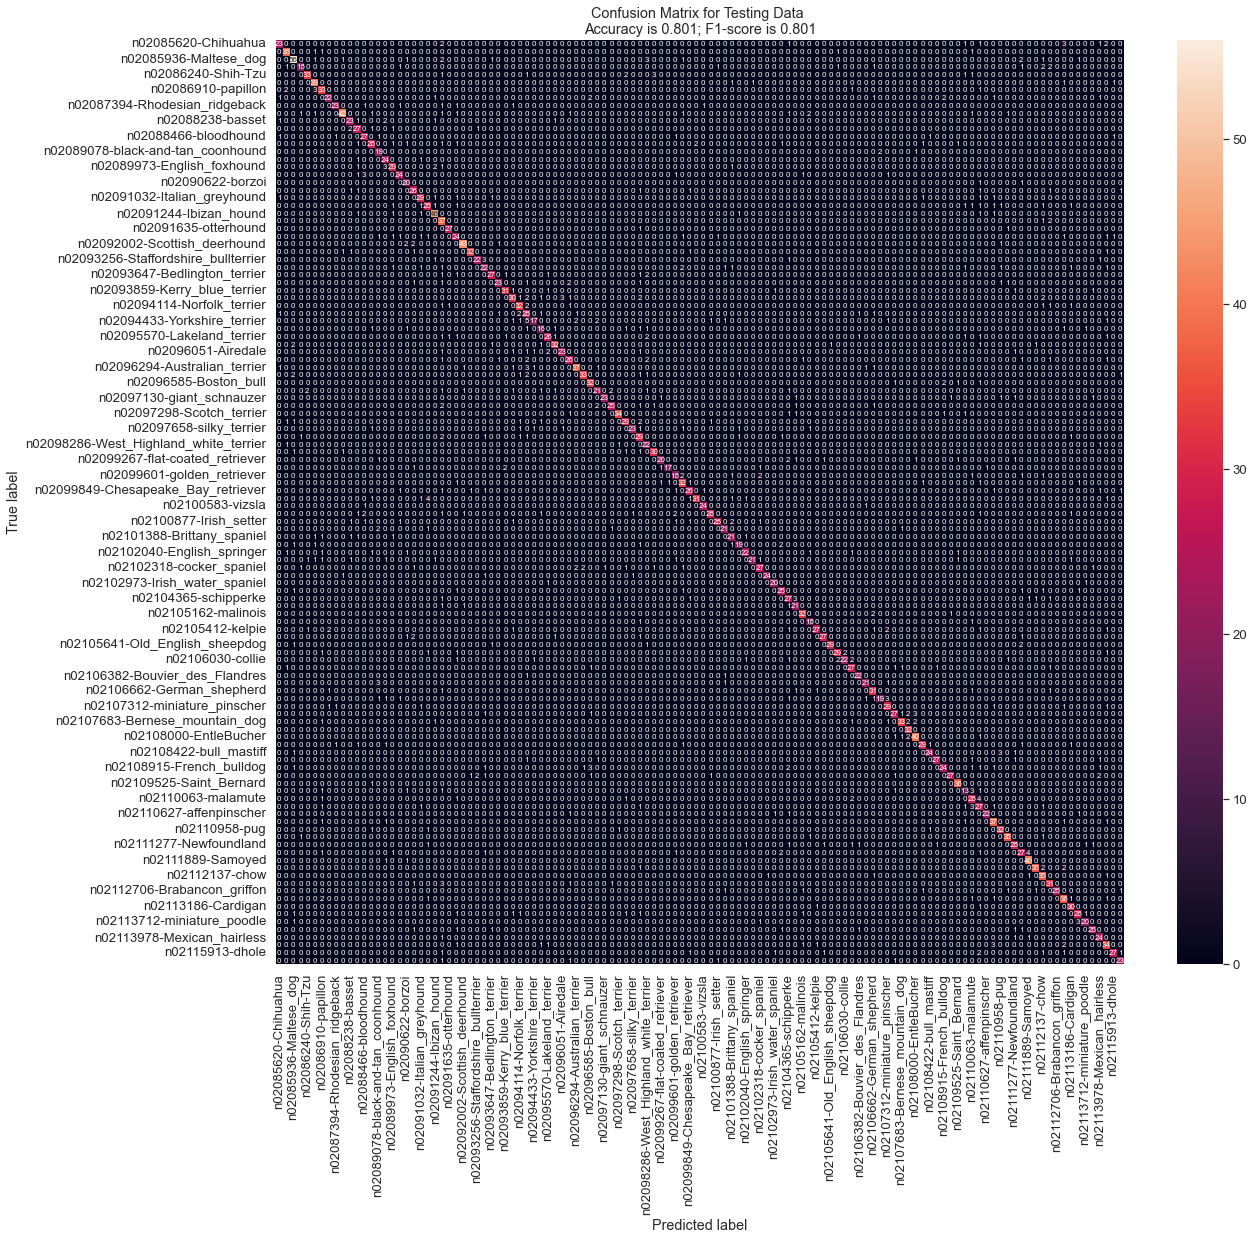

In [70]:
display_confusion_matrix("", 'mobilenet', y_true, preds_test, class_names, annot=True, figsize=(19, 17), fontsize=8)

In [71]:
images_path = './data/images/Images/'
results_path = images_path+'_results'
presplit = False
train_split = 0.7
val_split = 0.2
test_split = 0.1
batch_size = 64
threads = 18
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set = \
                  load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std)

In [72]:
device = torch.device('cuda:0')
model = mobilenet_v3_small(pretrained=False).to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-3
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=.9, weight_decay=.9, eps=.002)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_epochs = 75
l2_lambda = 1e-5

C:\Users\dstok\anaconda3\envs\ML\lib\site-packages\torchvision\models\mobilenetv2.py:25: FutureWarning: The ConvBNReLU/ConvBNActivation classes are deprecated since 0.12 and will be removed in 0.14. Use torchvision.ops.misc.ConvNormActivation instead.
  warnings.warn(


In [73]:
training(model, optimizer, loss_function, n_epochs, device, l2_lambda, training_set_loader)

Epoch: 0, Loss: 4.177763
Epoch: 1, Loss: 5.133218
Epoch: 2, Loss: 3.970359
Epoch: 3, Loss: 3.793832
Epoch: 4, Loss: 3.314423
Accuracy  0.09934418265727471
Epoch: 5, Loss: 4.656769
Epoch: 6, Loss: 2.822208
Epoch: 7, Loss: 4.615011
Epoch: 8, Loss: 3.885171
Epoch: 9, Loss: 4.504474
Accuracy  0.1542385231965023
Epoch: 10, Loss: 4.776655
Epoch: 11, Loss: 3.885466
Epoch: 12, Loss: 4.074168
Epoch: 13, Loss: 3.103129
Epoch: 14, Loss: 3.283391
Epoch: 15, Loss: 5.617229
Epoch: 16, Loss: 3.206001
Epoch: 17, Loss: 2.112771
Epoch: 18, Loss: 3.814596
Epoch: 19, Loss: 2.746618
Epoch: 20, Loss: 3.099161
Epoch: 21, Loss: 2.856380
Epoch: 22, Loss: 3.163967
Epoch: 23, Loss: 1.872744
Epoch: 24, Loss: 2.801200
Accuracy  0.26864221520524656
Epoch: 25, Loss: 1.689349
Epoch: 26, Loss: 3.115552
Epoch: 27, Loss: 4.349456
Epoch: 28, Loss: 2.328077
Epoch: 29, Loss: 3.382171
Accuracy  0.26961379645372846
Epoch: 30, Loss: 4.211298
Epoch: 31, Loss: 2.762098
Epoch: 32, Loss: 3.221095
Epoch: 33, Loss: 2.582465
Epoch: 

In [74]:
macs, params = get_model_complexity_info(model, (3, 224,224), as_strings=True, print_per_layer_stat=False, verbose=False)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Computational complexity:       0.06 GMac
Number of parameters:           1.64 M  


In [75]:
validate()

Accuracy  0.27034248239008984


In [76]:
torch.save(model.state_dict(), "./models/ANY%SmallModel.pt")

In [77]:
batch_size = 1
threads = 18
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set = \
                  load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std)

In [78]:
model.eval()
i = 0
true = 0
for img, label in validation_set_loader:
    img = img.to(device)
   # print(img.shape)
    label = label.to(device)
    output = model(img)
    # print("--------------------------------")
    # print("prediction: " + str(class_names[torch.argmax(output)]))
    # print(torch.argmax(output))
    # print("ground truth: " + str(class_names[label]))
    # print(label)
    # print("--------------------------------")
    # print("\n")
    if torch.argmax(output) == label:
        true += 1
    i += 1
print(true/i)

0.7418022832159339
